In [58]:
'''

GUILHERME LIMA DE SOUSA - 
ESTUDO DE CASO: TONELADAS TRANSPORTADAS EM FERROVIAS BRASILEIRAS
OBJETIVO: PREDIÇÃO USANDO RANDOMFORESTREGRESSOR

ENTRE EM CONTATO COMIGO NO LINKEDIN: 
www.linkedin.com/in/guilherme-lima-747355169

'''


import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import random



################################################################################


# ETL DA BASE

################################################################################



##CONFIGURANDO NUMEROS COM 2 CASAS DECIMAIS
pd.set_option('Float_format','{:.2f}'.format)

## COMPILANDO ARQUIVOS DA PASTA
pasta = 'C:/Users/Guilh/OneDrive/Área de Trabalho/1-MATERIAIS DE ESTUDO/01 - DIVERSOS/01-RANDOMFOREST/1-ANTT_FERROVIAS/01-INPUT'
arquivos = glob.glob(os.path.join(pasta, '*.csv'))
base_original = pd.concat([pd.read_csv(i, sep=';', encoding='latin1') for i in arquivos], ignore_index = True)

## REMOVENDO PONTO DA COLUNA
base_original['TU'] = base_original['TU'].str.replace('.','',regex=False)
base_original['TKU'] = base_original['TKU'].str.replace('.','',regex=False)

## ALTERANDO FORMATAÇÃO DA COLUNA
base_original['TKU'] = base_original['TKU'].fillna(0)
base_original['TKU'] = base_original['TKU'].astype(float)
base_original['TU'] = base_original['TU'].astype(int)
base_original['TKU'] = base_original['TKU'].astype(int)
base_original['Mes_Ano'] = pd.to_datetime(base_original['Mes_Ano'], format='%m/%Y')

## CRIANDO COLUNAS
base_original['MÊS'] = base_original['Mes_Ano'].dt.month
base_original['ANO'] = base_original['Mes_Ano'].dt.year

#REMOVENDO DUPLICADOS E NULOS
base_original = base_original.drop_duplicates()

# REMOVENDO COLUNA TKU POIS O OBJETIVO É APNAS TU
base_original = base_original.drop('TKU', axis=1)
base_original = base_original.drop('Mes_Ano', axis=1)

# REMOVENDO VALORES ABAIXO DE 1 TONELADA
base_original = base_original[base_original["TU"]>= 1]

# VENDO A BASE
base_original.head(-5)

,Ferrovia,Mercadoria_ANTT,Estacao_Origem,UF_Origem,Estacao_Destino,UF_Destino,TU,MÊS,ANO
0,EFC,Álcool,Itaqui Base Combustível,MA,Marabá,PA,184,1,2006
1,EFC,Bebidas e Vasilhames,Ponta da Madeira Pêra do Píer,MA,Imperatriz,MA,1636,1,2006
2,EFC,Cobre,Paraupebas,PA,Ponta da Madeira Cobre,MA,24461,1,2006
3,EFC,Ferro Gusa,Açailândia,MA,Ponta da Madeira Pêra do Píer,MA,116272,1,2006
4,EFC,Ferro Gusa,Marabá,PA,Ponta da Madeira Pêra do Píer,MA,205242,1,2006
...,...,...,...,...,...,...,...,...,...
148653,RMS,Soja,Marialva,PR,D Pedro II,PR,179173,4,2023
148654,RMS,Soja,Marialva,PR,São Francisco do Sul,SC,80527,4,2023
148655,RMS,Soja,Maringa,PR,D Pedro II,PR,193917,4,2023
148656,RMS,Soja,Maringa,PR,Rio Grande,RS,1710,4,2023


In [59]:
################################################################################


# ANALISE EXPLORATORIA DOS DADOS - EDA

################################################################################


base_original.describe()

,TU,MÊS,ANO
count,148622.00,148622.00,148622.00
mean,54625.18,6.47,2013.50
std,401350.82,3.46,5.17
min,1.00,1.00,2006.00
25%,981.00,3.00,2009.00
50%,4491.00,6.00,2013.00
75%,16913.75,9.00,2018.00
max,13858719.00,12.00,2023.00


In [60]:
################################################################################


# ANALISE EXPLORATORIA DOS DADOS - EDA

################################################################################

# INFOS RAPIDAS
base_original.info()
print('----------------------------------')

# DUPLICADOS
if base_original.duplicated().sum() > 0:
    print(f'Total de linhas duplicadas e excluidas: {base_original.duplicated().sum()}')
    base_original.drop_duplicates(inplace=True)
else:
    print('Não há dados duplicados')
print('----------------------------------')

<class 'pandas.core.frame.DataFrame'>
Index: 148622 entries, 0 to 148662
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Ferrovia         148622 non-null  object
 1   Mercadoria_ANTT  148622 non-null  object
 2   Estacao_Origem   148622 non-null  object
 3   UF_Origem        148622 non-null  object
 4   Estacao_Destino  148622 non-null  object
 5   UF_Destino       148622 non-null  object
 6   TU               148622 non-null  int64 
 7   MÊS              148622 non-null  int32 
 8   ANO              148622 non-null  int32 
dtypes: int32(2), int64(1), object(6)
memory usage: 10.2+ MB
----------------------------------
Não há dados duplicados
----------------------------------


In [61]:
################################################################################


# ANALISE EXPLORATÓRIA DO CONJUNTO DE DADOS

################################################################################


## COLUNAS CATEGORICAS REPRESENTATIVIDADE EM PERCENTUAL (CONTAGEM DE REGISTROS/TOTAL DE REGISTROS)
print('#########################################\n')
print('Representatividade das principais colunas\n')
print('#########################################\n')
print('---------- Ferrovias ----------')
print(base_original['Ferrovia'].value_counts(normalize=True))
print('----------------------------------')
print('---------- Mercadoria_ANTT ----------')
print(base_original['Mercadoria_ANTT'].value_counts(normalize=True))
print('----------------------------------')
print('---------- Estacao_Origem ----------')
print(base_original['Estacao_Origem'].value_counts(normalize=True))
print('----------------------------------')
print('---------- Estacao_Destino ----------')
print(base_original['Estacao_Destino'].value_counts(normalize=True))
print('----------------------------------')
print('---------- UF_Origem ----------')
print(base_original['UF_Origem'].value_counts(normalize=True))
print('----------------------------------')
print('---------- UF_Destino ----------')
print(base_original['UF_Destino'].value_counts(normalize=True))
print('----------------------------------')

#########################################

Representatividade das principais colunas

#########################################

---------- Ferrovias ----------
Ferrovia
MRS     0.29
RMS     0.26
EFVM    0.13
FCA     0.13
FTL     0.05
RMP     0.05
RMN     0.03
EFC     0.02
RMO     0.01
EFPO    0.01
FNSTN   0.01
FTC     0.01
RMC     0.00
Name: proportion, dtype: float64
----------------------------------
---------- Mercadoria_ANTT ----------
Mercadoria_ANTT
Minério de Ferro                          0.09
Prd. Siderúrgicos - Outros                0.06
Contêiner Cheio de 40 Pés                 0.06
Óleo Diesel                               0.05
Soja                                      0.05
                                          ... 
Produtos Químicos - Perigoso              0.00
Farelo de Milho                           0.00
Outras - C Geral Não Contein - Perigoso   0.00
Óleo Cru                                  0.00
Fosfato - Perigoso                        0.00
Name: proportion, Leng

#########################################
EDA COLUNAS NÚMERICAS
----------------------------------


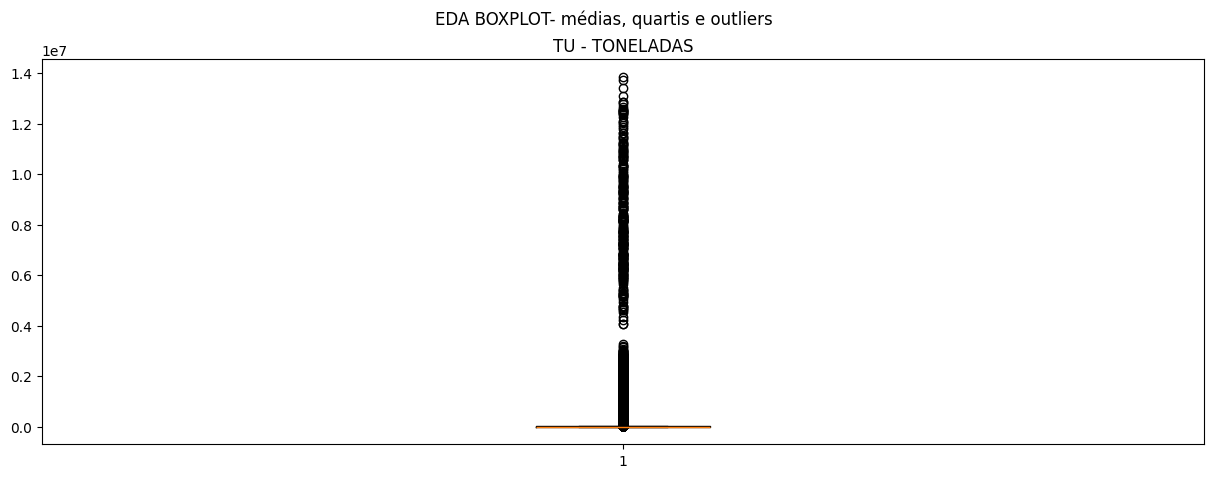

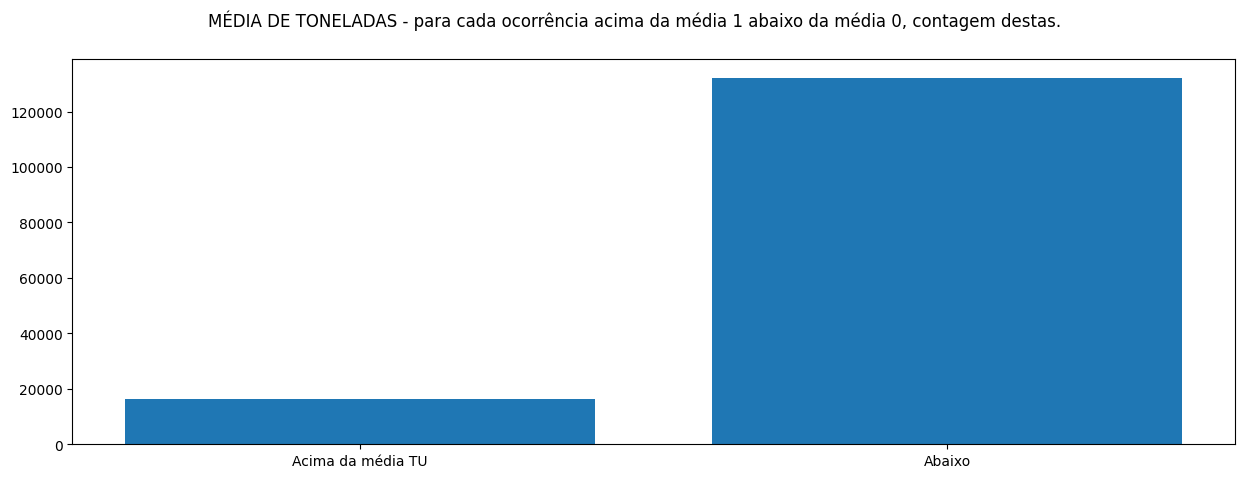

In [62]:
################################################################################


# ANALISE EXPLORATORIA DOS DADOS - EDA

################################################################################



## COLUNAS NÚMERICAS
print('#########################################')
print('EDA COLUNAS NÚMERICAS')
print('----------------------------------')

figura = plt.figure(figsize=(15,5))
figura.suptitle('EDA BOXPLOT- médias, quartis e outliers')

figura.add_subplot(111)
plt.boxplot(base_original['TU'], showfliers=True)
plt.title('TU - TONELADAS')


######
#########################################

# CRIANDO UMA FLAG NA BASE ACIMA OU ABAIXO DA MEDIA
base_original['FLAG_MEDIA_TU'] = np.where(base_original['TU'] >= base_original['TU'].mean(),1,0)
#print(base_original)


figura_2 = plt.figure(figsize=(15,5))
figura_2.suptitle('MÉDIA DE TONELADAS - para cada ocorrência acima da média 1 abaixo da média 0, contagem destas.')


figura_2.add_subplot(111)
acima_tu = base_original[base_original['FLAG_MEDIA_TU'] == 1]['FLAG_MEDIA_TU'].count()
abaixo_tu = base_original[base_original['FLAG_MEDIA_TU'] == 0]['FLAG_MEDIA_TU'].count()
plt.bar(['Acima da média TU', 'Abaixo'], [acima_tu, abaixo_tu])


plt.show()

##################################################

Curtose de Pearson (bruta): 483.4907

##################################################



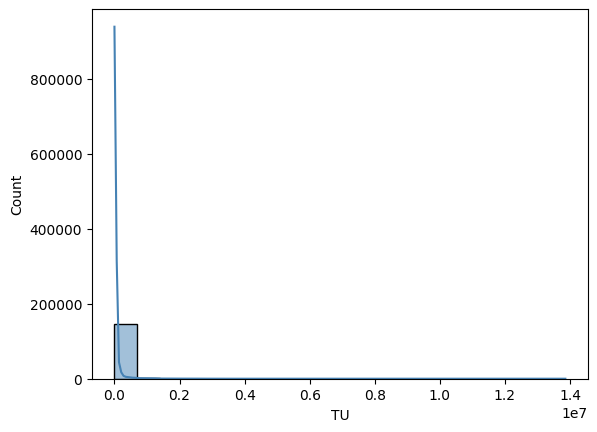

In [63]:
################################################################################


# ANALISE EXPLORATORIA DOS DADOS - EDA

################################################################################

from scipy.stats import kurtosis


##  CURTOSE - KURTOSIS
print('##################################################\n')
curtose_toneladas_log10 = kurtosis(base_original['TU'], fisher=False)
print(f"Curtose de Pearson (bruta): {curtose_toneladas_log10:.4f}")
print('\n##################################################\n')


# DISTRIBUIÇÃO DOS DADOS
sns.histplot(base_original['TU'], kde=True, bins=20, color='steelblue')
plt.show()

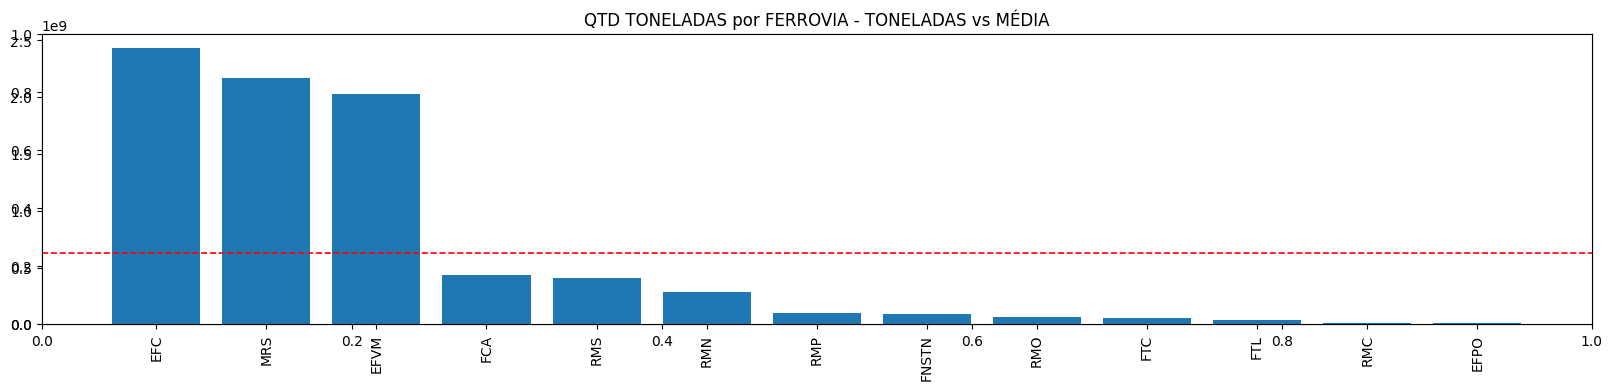

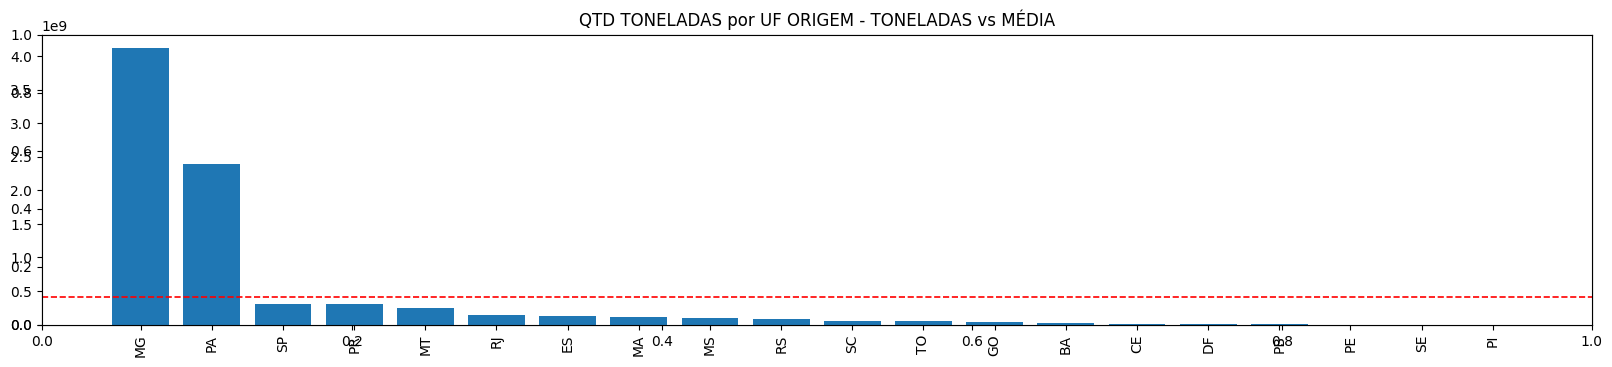

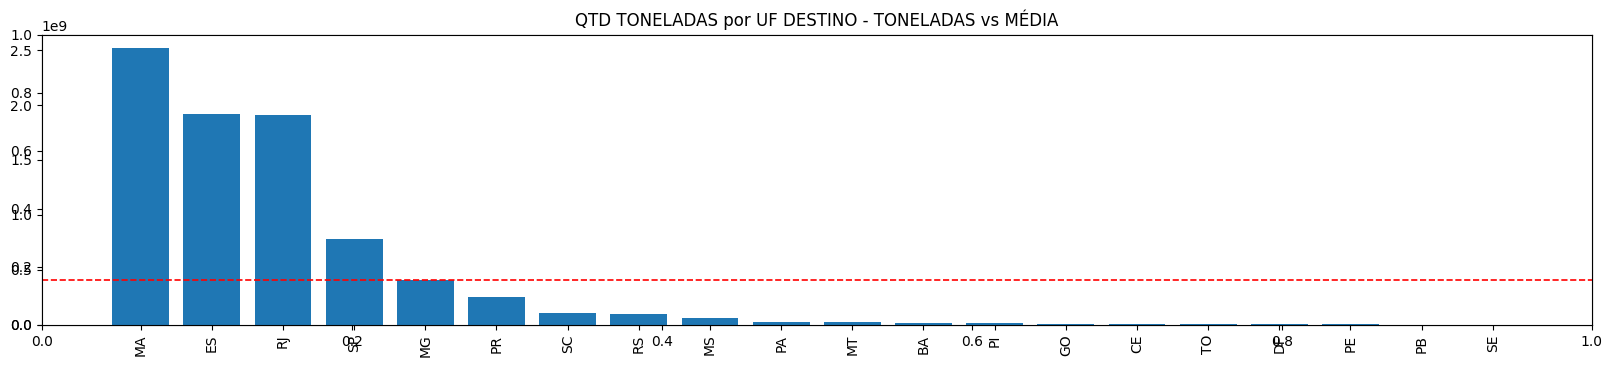

In [64]:
################################################################################


# ANALISE EXPLORATORIA DOS DADOS - EDA

################################################################################


############  FIGURA 1
figura = plt.figure(figsize=(20,5))
plt.title('QTD TONELADAS por FERROVIA - TONELADAS vs MÉDIA')


figura.add_subplot(111)
um = base_original.groupby('Ferrovia')['TU'].sum().reset_index().sort_values(by='TU', ascending=False)
plt.bar(um['Ferrovia'], um['TU'])
plt.xticks(rotation=90)
plt.subplots_adjust(bottom=0.3)
plt.axhline(y= np.mean(um['TU']), color='red', linestyle='--', linewidth=1.2)


############  FIGURA 2
figura2 = plt.figure(figsize=(20,5))
plt.title('QTD TONELADAS por UF ORIGEM - TONELADAS vs MÉDIA')

figura2.add_subplot(111)
dois = base_original.groupby('UF_Origem')['TU'].sum().reset_index().sort_values(by='TU', ascending=False)
plt.bar(dois['UF_Origem'], dois['TU'])
plt.xticks(rotation=90)
plt.subplots_adjust(bottom=0.3)
plt.axhline(y= np.mean(dois['TU']), color='red', linestyle='--', linewidth=1.2)


############ FIGURA 3
figura3 = plt.figure(figsize=(20,5))
plt.title('QTD TONELADAS por UF DESTINO - TONELADAS vs MÉDIA')

figura3.add_subplot(111)
dois = base_original.groupby('UF_Destino')['TU'].sum().reset_index().sort_values(by='TU', ascending=False)
plt.bar(dois['UF_Destino'], dois['TU'])
plt.xticks(rotation=90)
plt.subplots_adjust(bottom=0.3)
plt.axhline(y= np.mean(dois['TU']), color='red', linestyle='--', linewidth=1.2)


plt.show()
#teste.sort_values(by='TU', ascending=False)

In [65]:
'''

AQUI VAMOS CRIAR O DATASET DO MODELO
FAZENDO ETL COM AS COLUNAS CATEGORICAS E APLICANDO CÓDIGOS PARA CADA UMA, 
POSTERIORMENTE USANDO AS COLUNAS NUMERICAS REPRESENTADAS COMO VARIAVEIS DO MODELO.
EM VEZ DE USAR O NOME DA FERROVIA ESTAMOS CRIANDO UM CÓDIGO DISTINTO DELA.

'''


####################################################################################

#     CRIANDO DATASET DO MODELO

####################################################################################

# REPRODUTIBILIDADE
np.random.seed(2)


## BASE MODELO
#print(base_original.columns)
print('--------------------')
base_modelo = base_original


# REMOVENDO COLUNA FLAG POIS É UM INCREMENTO
base_modelo = base_modelo.drop('FLAG_MEDIA_TU', axis=1)

# DUMMIES
#base_modelo = pd.get_dummies(base_original)

# TRANSFORMANDO COLUNAS
base_modelo['ANO'] = base_modelo['ANO'].astype(int)
base_modelo['MÊS'] = base_modelo['MÊS'].astype(int)
base_modelo['TU'] = base_modelo['TU'].astype(int)

#
############### CRIANDO OS CÓDIGOS DE CADA CATEGORIA
# SELECIONA APENAS AS COLUNAS STRING/CATEGORIAS/OBJETO
categ = base_modelo.select_dtypes(include=['object', 'category']).copy()
# LAMBDA QUE TRANSFORMA AS COLUNAS E NUMEROS
cod_categorica_hoje_1 = categ.apply(lambda col: col.astype('category').cat.codes)
# RENOMEANDO AS COLUNAS DE CODIGO COM PREFIXO
cod_categorica_1 = cod_categorica_hoje_1.add_prefix('Codigo_')


# CONCATENANDO AS BASES DE CODIGOS COM A ORIGINAL
codigos_categorias = pd.concat([base_modelo, cod_categorica_1], axis=1)

print('################# BASE COM DE:PARA ########################\n')
# BASE COM TUDO
codigos_categorias.head(1)


##########  PARA VISUALIZAR DE:PARA DE COLUNA ESPECIFICA
#visualizar_de_para = codigos_categorias[['Ferrovia', 'Codigo_Ferrovia']].drop_duplicates().reset_index(drop=True)
#print('\n################# VERIFICAR ########################\n')
#print(visualizar_de_para.head(3))



--------------------
################# BASE COM DE:PARA ########################



,Ferrovia,Mercadoria_ANTT,Estacao_Origem,UF_Origem,Estacao_Destino,UF_Destino,TU,MÊS,ANO,Codigo_Ferrovia,Codigo_Mercadoria_ANTT,Codigo_Estacao_Origem,Codigo_UF_Origem,Codigo_Estacao_Destino,Codigo_UF_Destino
0,EFC,Álcool,Itaqui Base Combustível,MA,Marabá,PA,184,1,2006,0,98,216,5,234,9


In [66]:
####################################################################################

#     TRANSFORMANDO DATASET DO MODELO RANDOMFOREST

####################################################################################

''' 
AQUI ESTOU REMOVENDO OS VALORES MENORES DE 1000 MIL TONELADAS DE MOVIMENTAÇÃO
POIS ABAIXO DE MIL DEIXA O MODELO RUIM, MUITO COMPLEXO PRA ENTENDER OS DADOS

'''
# CRIANDO A BASE
base_treino = codigos_categorias.select_dtypes(exclude=['object', 'category']).copy()

#REMOVENDO DUPLICADOS
base_treino = base_treino.drop_duplicates()
base_treino = base_treino.fillna(0)

# SALVANDO BASE DO MODELO COMPLETA SEM FILTROS
base_modelo_completa = base_treino

# LIMITANDO A BASE REMOVENDO 2023
base_treino = base_treino[base_treino['ANO'] != 2023][list(base_treino.columns)]


# REMOVENDO OS OUTLIERS - TUDO QUE É MENOR DE MIL TONELADAS
base_treino = base_treino[base_treino['TU'] >= 1000.00]
base_modelo = base_treino


# REMOVENDO OS OUTLIERS - TUDO QUE ESTÁ MAIOR DO 3º QUARTIL EM TONELADAS
#q3 = base_treino['TU'].quantile(0.75)
#base_treino = base_treino[base_treino['TU'] <= q3]
#base_modelo = base_treino



# LOGARITMO BASE10
base_modelo['TU_LOG10'] = np.log10(base_modelo['TU'])

# REMOVENDO COLUNA REAL
base_modelo = base_modelo.drop('TU', axis=1)


base_modelo = base_modelo[["MÊS", "ANO", "Codigo_Ferrovia", "Codigo_Mercadoria_ANTT",
                          "Codigo_Estacao_Origem", "Codigo_UF_Origem", "Codigo_Estacao_Destino",
                          "Codigo_UF_Destino", "TU_LOG10"]]


print('################# BASE MODELO ########################')
print(base_modelo.head(3))
print('################# BASE MODELO ########################')
base_modelo.describe()


################# BASE MODELO ########################
   MÊS   ANO  Codigo_Ferrovia  Codigo_Mercadoria_ANTT  Codigo_Estacao_Origem  \
1    1  2006                0                      11                    316   
2    1  2006                0                      22                    293   
3    1  2006                0                      44                     36   

   Codigo_UF_Origem  Codigo_Estacao_Destino  Codigo_UF_Destino  TU_LOG10  
1                 5                     187                  5      3.21  
2                 9                     296                  5      4.39  
3                 5                     297                  5      5.07  
################# BASE MODELO ########################


,MÊS,ANO,Codigo_Ferrovia,Codigo_Mercadoria_ANTT,Codigo_Estacao_Origem,Codigo_UF_Origem,Codigo_Estacao_Destino,Codigo_UF_Destino,TU_LOG10
count,109216.00,109216.00,109216.00,109216.00,109216.00,109216.00,109216.00,109216.00,109216.00
mean,6.55,2013.46,6.90,53.71,234.52,10.26,224.13,11.75,4.03
std,3.43,5.00,3.92,30.10,127.57,5.37,121.22,5.59,0.68
min,1.00,2006.00,0.00,0.00,1.00,0.00,0.00,0.00,3.00
25%,4.00,2009.00,3.00,23.00,132.00,6.00,127.00,6.00,3.51
50%,7.00,2013.00,7.00,59.00,247.00,9.00,233.00,13.00,3.92
75%,10.00,2018.00,12.00,81.00,341.00,15.00,340.00,18.00,4.42
max,12.00,2022.00,12.00,101.00,437.00,19.00,410.00,19.00,7.14


##################################################
 O ano maximo dataset de treino é:
 {np.int64(2022)}
##################################################

 Colunas da base final:
 Index(['MÊS', 'ANO', 'Codigo_Ferrovia', 'Codigo_Mercadoria_ANTT',
       'Codigo_Estacao_Origem', 'Codigo_UF_Origem', 'Codigo_Estacao_Destino',
       'Codigo_UF_Destino', 'TU_LOG10'],
      dtype='object')
##################################################

Curtose de Pearson (bruta): 3.9091
##################################################



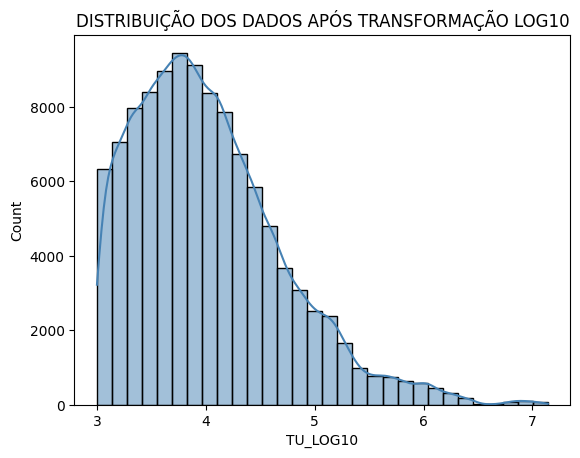

In [67]:
################################################################################


# ANALISE EXPLORATORIA DOS DADOS QUE VAO AO MODELO - EDA

################################################################################

'''

ESTE EDA SERÁ FEITO PARA PODERMOS COMPARAR A DISTRIBUIÇÃO ANTERIOR COM A 
DISTRIBUIÇÃO APÓS TRANSFORMAÇÃO LOGARITMICA

'''


# REPRODUTIBILIDADE
np.random.seed(2)

# ########  VERIFICANDO A BASE ANTES DE ENVIAR AO MODELO
print('##################################################')
print(' O ano maximo dataset de treino é:\n', {base_modelo['ANO'].max()})
print('##################################################\n')
print(' Colunas da base final:\n', base_modelo.columns)


##  CURTOSE - KURTOSIS
print('##################################################\n')
curtose_toneladas_log10 = kurtosis(base_modelo['TU_LOG10'], fisher=False)
print(f"Curtose de Pearson (bruta): {curtose_toneladas_log10:.4f}")



# DISTRIBUIÇÃO DO DATASET COM LOG10
print('##################################################\n')
sns.histplot(base_modelo['TU_LOG10'], kde=True, bins=30, color='steelblue')
plt.title('DISTRIBUIÇÃO DOS DADOS APÓS TRANSFORMAÇÃO LOG10')
plt.show()

In [68]:
################################################################################


# ANALISE EXPLORATORIA DOS DADOS QUE VAO AO MODELO - EDA

################################################################################


base_modelo.describe()

,MÊS,ANO,Codigo_Ferrovia,Codigo_Mercadoria_ANTT,Codigo_Estacao_Origem,Codigo_UF_Origem,Codigo_Estacao_Destino,Codigo_UF_Destino,TU_LOG10
count,109216.00,109216.00,109216.00,109216.00,109216.00,109216.00,109216.00,109216.00,109216.00
mean,6.55,2013.46,6.90,53.71,234.52,10.26,224.13,11.75,4.03
std,3.43,5.00,3.92,30.10,127.57,5.37,121.22,5.59,0.68
min,1.00,2006.00,0.00,0.00,1.00,0.00,0.00,0.00,3.00
25%,4.00,2009.00,3.00,23.00,132.00,6.00,127.00,6.00,3.51
50%,7.00,2013.00,7.00,59.00,247.00,9.00,233.00,13.00,3.92
75%,10.00,2018.00,12.00,81.00,341.00,15.00,340.00,18.00,4.42
max,12.00,2022.00,12.00,101.00,437.00,19.00,410.00,19.00,7.14


In [70]:

'''

HIPÓTESE NULA = SERÁ QUE MEU MODELO CONSEGUE EXPLICAR AS TONELADAS TRANSPORTADAS
APENAS COM AS DEMAIS COLUNAS DO NOSSO DATASET ?

############# PARAMETROS DO MODELO
MODELO COM VALIDAÇÃO CRUZADA DE 5 FOLDS CRIADO COM OS PARAMETROS:

MAXDEPTH = 5 
PERMITE CRIAR ARVORES MAIS PROFUNDAS E TRAZ ALEATORIEDADE AOS DADOS, GENERALIZAÇÃO.

N_ESTIMATORS = 10
10 ARVORES DE DECISÃO NO MÁXIMO

RANDOM_STATE = 2
REPLICABILIDADE DE RESULTADOS


############# AVALIAÇÕES
# MAE (ERRO ABSOLUTO MEDIO)
Em média, o modelo erra cerca de 1.900 toneladas na previsão de TU. Esse valor deve ser 
interpretado em relação à escala dos dados — se TU varia de 0 a milhões, 
esse erro pode ser tolerável; se não, pode ser alto ......Em nossa base a coluna TARGET varia entre 0 e 13.858.719.00
1900 é tolerável


# RMSE
Raiz do erro quadratico médio - (Raise mean squared error)
Esse erro penaliza mais fortemente grandes erros. Um RMSE muito maior que o MAE (como no nosso cenario 3.200) indica que 
há outliers ou erros muito grandes em alguns casos que estão influenciando bastante a performance.

# MAPE
Este é o erro médio MAE só que em percentual.

# MEDAE
Este é a mediana dos erros, mostra como os erros estão distribuidos, o meio entre eles.

Avaliamos:
MAE para entender o erro médio em “unidades reais”.
RMSE se quiser punir grandes erros.
MAPE se quiser o erro em %, fácil de interpretar.
MedAE se houver outliers (valores muito fora da curva).

'''

# REPRODUTIBILIDADE
np.random.seed(2)

############################################################################


#  CIRANDO O MODELO E APLICANDO NA BASE DE TREINO

############################################################################


from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split, learning_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, classification_report
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, median_absolute_error


# DEFININDO X (VAR DEPENDENTE) Y (VAR TARGET)
x = base_modelo.drop(columns=['TU_LOG10'])
y = base_modelo['TU_LOG10']


# SEPARANDO TREINO E TESTE
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.1)

# CRIANDO MODELO (10 arvores, profundidade 5, replicabilidade seed 2)
modelo = RandomForestRegressor(n_estimators=10, max_depth=5, random_state=2)

# VALIDAÇÃO CRUZADA
kf = KFold(n_splits=5, shuffle= True, random_state=2)
cross_validation = cross_val_score(modelo, x, y, cv=kf, scoring='r2')

# APLICANDO LOG() PARA MELHORAR A DISTRIBUIÇÃO DO MODELO - evita heterocedasticidade
#y_train_log = np.log1p(y_train)


# TREINANDO O MODELO
modelo.fit(x_train, y_train)


# USANDO MODELO NO COJUNTO DE TESTE - PREDIÇÃO
y_pred = modelo.predict(x_test)

# OBTENDO R2 DA PREDIÇÃO ANTERIOR
r2_test = r2_score(y_test, y_pred)

# ERRO PERCENTUAL MÉDIO COM LOG10
MAE_LOG10 = mean_absolute_error(y_test, y_pred)
RMSE_LOG10 = np.sqrt(mean_squared_error(y_test, y_pred))
MAPE_LOG10 = mean_absolute_percentage_error(y_test, y_pred)
MEDAE_LOG10 = median_absolute_error(y_test, y_pred)


# ERRO PERCENTUAL MÉDIO SEM LOG10
MAE_REAL = mean_absolute_error(10**y_test, 10**y_pred)
RMSE_REAL = np.sqrt(mean_squared_error(10**y_test, 10**y_pred))
MAPE_REAL = mean_absolute_percentage_error(10**y_test, 10**y_pred)
MEDAE_REAL = median_absolute_error(10**y_test, 10**y_pred)


########## RESULTADOS VALIDAÇÃO CRUZADA
print('----------  RESULTADOS VALIDAÇÃO CRUZADA  ----------')
print(f"O tipo do modelo carregado é: {type(modelo)}")
print(f"Acuracia para cada fold (cross-validation): {cross_validation}")
print(f"Acuracia média (cross-validation): {cross_validation.mean()*100}")
print(f"Desvio padrão (cross validation): {cross_validation.std()}")
print(f"R² no conjunto de teste: {r2_test:.2f}")
print("MAE:", MAE_REAL)
print("RMSE:", RMSE_REAL)
print(f"MAPE: {MAPE_REAL:.2%}")
print(f"MedAE: {MEDAE_REAL:.2f}")



###################################################################

#   SALVANDO MODELO

###################################################################


from joblib import dump, load

print('####################################################')
print('----------  SALVANDO MODELO  ----------')
dump(modelo,'ANTT_RANDOMFORESTREGRESSOR.joblib')

----------  RESULTADOS VALIDAÇÃO CRUZADA  ----------
O tipo do modelo carregado é: <class 'sklearn.ensemble._forest.RandomForestRegressor'>
Acuracia para cada fold (cross-validation): [0.44116226 0.43119652 0.44544538 0.44417819 0.42601058]
Acuracia média (cross-validation): 43.75985864660376
Desvio padrão (cross validation): 0.0076528629148899545
R² no conjunto de teste: 0.44
MAE: 65143.94819505441
RMSE: 464205.69970473024
MAPE: 145.55%
MedAE: 5514.32
####################################################
----------  SALVANDO MODELO  ----------


['ANTT_RANDOMFORESTREGRESSOR.joblib']

In [71]:

'''

HIPÓTESE NULA = SERÁ QUE MEU MODELO CONSEGUE EXPLICAR AS TONELADAS TRANSPORTADAS
APENAS COM AS DEMAIS COLUNAS DO NOSSO DATASET ?


############# PARAMETROS DO MODELO
MODELO COM VALIDAÇÃO CRUZADA DE 5 FOLDS CRIADO COM OS PARAMETROS:

N_ESTIMATORS = 300
300 ARVORES DE DECISÃO NO MÁXIMO

MAXDEPTH = 15
PERMITE CRIAR ARVORES MAIS PROFUNDAS E TRAZ ALEATORIEDADE AOS DADOS, GENERALIZAÇÃO.

RANDOM_STATE = 2
REPLICABILIDADE DE RESULTADOS

MAX_FEATURES = 'SQRT' 
ELE NÃO USA TODAS AS FEATURES NOS NÓS, ELE USA A RAIZ QUADRADA DO TOTAL DE COLUNAS.
DESTA FORMA O MODELO É FORÇADO COM DADOS E CENÁRIOS COMPLEXOS.

MIN_SAMPLES_SPLIT = 10
O MODELO SÓ VAI CRIAR OUTRO NÓ SE TIVER PELO MENOS 10 REGISTROS PRA SEGUIR ADIANTE

MIN_SAMPLES_LEAF = 5
CADA FOLHA FINAL DEVE CONTER PELO MENOS 5 REGISTROS


############# AVALIAÇÕES
# MAE (ERRO ABSOLUTO MEDIO)
Em média, o modelo erra cerca de 1.560 toneladas na previsão de TU. Esse valor deve ser 
interpretado em relação à escala dos dados — se TU varia de 0 a milhões, 
esse erro pode ser tolerável; se não, pode ser alto ......Em nossa base a coluna TARGET varia entre 0 e 13.858.719.00
1560 é tolerável

# MAPE
Este é o erro médio MAE só que em percentual.

# RMSE
Raiz do erro quadratico médio - (Raise mean squared error)
Esse erro penaliza mais fortemente grandes erros. Um RMSE muito maior que o MAE (como no nosso cenario 2.650) indica que 
há outliers ou erros muito grandes em alguns casos que estão influenciando bastante a performance.

# MEDAE
Este é a mediana dos erros, mostra como os erros estão distribuidos, o meio entre eles.

Avaliamos:
MAE para entender o erro médio bruto.
MAPE é o MAE em %.
RMSE se quiser punir grandes erros, fica sempre maior mas não tanto.
MedAE onde é o meio ? mediana dos erros.

'''

# REPRODUTIBILIDADE
np.random.seed(2)

############################################################################


#  AJUSTANDO OS PARAMETROS DO MODELO

############################################################################


from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split, learning_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, classification_report
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, median_absolute_error


# DEFININDO X (VAR DEPENDENTE) Y (VAR TARGET)
x = base_modelo.drop(columns=['TU_LOG10'])
y = base_modelo['TU_LOG10']


# SEPARANDO TREINO E TESTE
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.1)

# CRIANDO MODELO
modelo = RandomForestRegressor(n_estimators=300, 
                               max_depth=15, 
                               random_state=2, 
                               max_features='sqrt', 
                               min_samples_split=10, 
                               min_samples_leaf=5)

# VALIDAÇÃO CRUZADA
kf = KFold(n_splits=5, shuffle= True, random_state=2)
cross_validation = cross_val_score(modelo, x, y, cv=kf, scoring='r2')

# APLICANDO LOG() PARA MELHORAR A DISTRIBUIÇÃO DO MODELO - evita heterocedasticidade
#y_train_log = np.log1p(y_train)


# TREINANDO O MODELO
modelo.fit(x_train, y_train)


# USANDO MODELO NO COJUNTO DE TESTE - PREDIÇÃO
y_pred = modelo.predict(x_test)

# OBTENDO R2 DA PREDIÇÃO ANTERIOR
r2_test = r2_score(y_test, y_pred)



# ERRO PERCENTUAL MÉDIO COM LOG10
MAE_LOG10 = mean_absolute_error(y_test, y_pred)
RMSE_LOG10 = np.sqrt(mean_squared_error(y_test, y_pred))
MAPE_LOG10 = mean_absolute_percentage_error(y_test, y_pred)
MEDAE_LOG10 = median_absolute_error(y_test, y_pred)


# ERRO PERCENTUAL MÉDIO SEM LOG10
MAE_REAL = mean_absolute_error(10**y_test, 10**y_pred)
RMSE_REAL = np.sqrt(mean_squared_error(10**y_test, 10**y_pred))
MAPE_REAL = mean_absolute_percentage_error(10**y_test, 10**y_pred)
MEDAE_REAL = median_absolute_error(10**y_test, 10**y_pred)


########## RESULTADOS VALIDAÇÃO CRUZADA
print('----------  RESULTADOS VALIDAÇÃO CRUZADA  ----------')
print(f"O tipo do modelo carregado é: {type(modelo)}")
print(f"Acuracia para cada fold (cross-validation): {cross_validation}")
print(f"Acuracia média (cross-validation): {cross_validation.mean()*100}")
print(f"Desvio padrão (cross validation): {cross_validation.std()}")
print(f"R² no conjunto de teste: {r2_test:.2f}")
print("MAE:", MAE_REAL)
print("RMSE:", RMSE_REAL)
print(f"MAPE: {MAPE_REAL:.2%}")
print(f"MedAE: {MEDAE_REAL:.2f}")



###################################################################

#   SALVANDO MODELO

###################################################################


from joblib import dump, load

print('####################################################')
print('----------  SALVANDO MODELO  ----------')
dump(modelo,'ANTT_RANDOMFORESTREGRESSOR.joblib')

----------  RESULTADOS VALIDAÇÃO CRUZADA  ----------
O tipo do modelo carregado é: <class 'sklearn.ensemble._forest.RandomForestRegressor'>
Acuracia para cada fold (cross-validation): [0.79555957 0.79177808 0.79553616 0.79339211 0.79126639]
Acuracia média (cross-validation): 79.35064605190799
Desvio padrão (cross validation): 0.0018084923567351864
R² no conjunto de teste: 0.80
MAE: 38327.93362254919
RMSE: 274067.86251617176
MAPE: 73.33%
MedAE: 3261.38
####################################################
----------  SALVANDO MODELO  ----------


['ANTT_RANDOMFORESTREGRESSOR.joblib']

In [72]:
'''

A TABELA DE PREDIÇÕES AJUDA A ENTENDER O COMPORTAMENTO DO MODELO, PERMITE
VISUALIZAR AS COLUNAS DE VALORES REAIS vs VALORES PREDITOS.
PERMITE VISUALIZAR O ERRO.

'''


############################################################################


# VALIDAÇÃO DO MODELO


############################################################################


# REPRODUTIBILIDADE
np.random.seed(2)


# TABELA FINAL DE RESULTADOS:
y_true = y_test.reset_index(drop=True)


# TABELA DE RESULTADOS COM A TRANSFORMAÇÃO LOG10
resultados = pd.DataFrame({
    'Valor LOG10': y_true,
    'Valor Predito': y_pred,
    'Residuo': (y_true - y_pred),
    'Erro Absoluto': abs(y_true - y_pred),
    'Erro Percentual (%)': abs((y_true - y_pred) / y_true) * 100
}).sort_values('Erro Percentual (%)', ascending=False)


# TABELA DE RESULTADOS SEM A TRANSFORMAÇÃO LOG10
resultados_2 = pd.DataFrame({
    'Valor Real': 10 ** y_true,
    'Valor Predito': 10 ** y_pred,
    'Residuo': (10 ** y_true - 10 ** y_pred),
    'Erro Absoluto': abs(10 ** y_true - 10 ** y_pred),
    'Erro Percentual (%)': abs((10 ** y_true - 10 ** y_pred) / 10 ** y_true) * 100
}).sort_values('Erro Percentual (%)', ascending=False)


# MEDIDAS RAPIDAS
mediana_erro_absoluto_log10 = resultados['Erro Absoluto'].median()
mediana_erro_absoluto = resultados_2['Erro Absoluto'].median()

# VISUALIZANDO AS INFORMAÇÕES
print(f"Mediana dos erros em LOG10: {mediana_erro_absoluto_log10:.2f}")
print(f"Mediana dos erros real: {mediana_erro_absoluto:.2f}")
print('Eu posso pegar apenas os erros acima da mediana e retreinar o modelo')
print('\n############## TABELA VALIDAÇÃO LOG10 #############################')
print(resultados.head(3))

print('\n############## TABELA VALIDAÇÃO REAL #############################')
print(resultados_2.head(3))

Mediana dos erros em LOG10: 0.20
Mediana dos erros real: 3261.38
Eu posso pegar apenas os erros acima da mediana e retreinar o modelo

############## TABELA VALIDAÇÃO LOG10 #############################
      Valor LOG10  Valor Predito  Residuo  Erro Absoluto  Erro Percentual (%)
989          3.04           4.80    -1.77           1.77                58.19
8545         3.20           4.86    -1.66           1.66                51.74
921          3.02           4.46    -1.45           1.45                47.90

############## TABELA VALIDAÇÃO REAL #############################
      Valor Real  Valor Predito   Residuo  Erro Absoluto  Erro Percentual (%)
989      1088.00       63640.79 -62552.79       62552.79              5749.34
8545     1584.00       71690.86 -70106.86       70106.86              4425.94
921      1041.00       29019.99 -27978.99       27978.99              2687.70


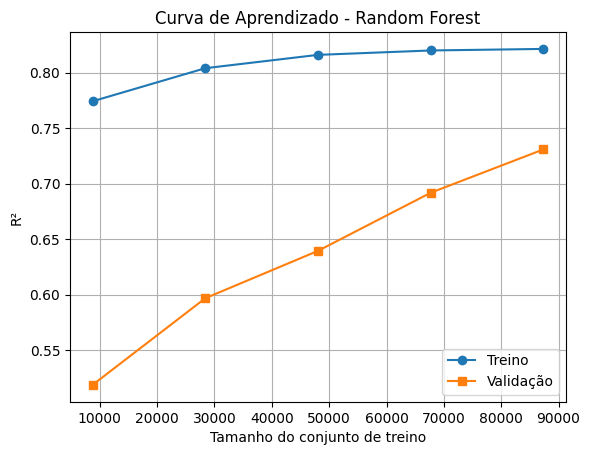

In [73]:
############################################################################


# VALIDAÇÃO DO MODELO


############################################################################


''' 

A curva de aprendizado mostra a generalização do modelo em relação aos dados de treino x teste.
Perceba que na linha azul do gráfico, os numeros ficam sempre próximos de 1 (100%) ....mas quando
olhamos a linha laranja os números começam em ~64 e estabilizam em ~80.

O modelo está aprendendo demais o treino, mas não aprende padrões gerais, por isso ele generaliza mal nos registros novos/teste.
Isso caracteriza Overfitting (sobreajuste) pois o modelo aprendeu demais no treino e fixou aquilo como regra.

'''
# REPRODUTIBILIDADE
np.random.seed(2)

# CURVA DE APRENDIZADO

train_sizes, train_scores, test_scores = learning_curve(
    modelo, x, y, cv=5, scoring='r2', n_jobs=-1 )

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_mean, label='Treino', marker='o')
plt.plot(train_sizes, test_mean, label='Validação', marker='s')
plt.xlabel('Tamanho do conjunto de treino')
plt.ylabel('R²')
plt.title('Curva de Aprendizado - Random Forest')
plt.legend()
plt.grid(True)
plt.show()


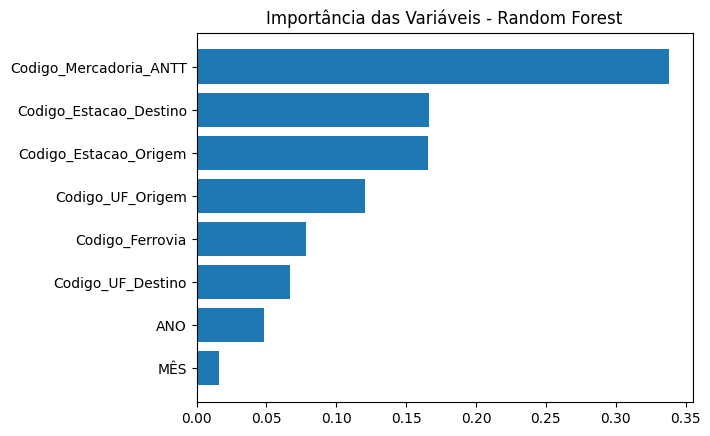

In [74]:
############################################################################


# VALIDAÇÃO DO MODELO


############################################################################


'''  

FEATURE IMPORTANCE permite verificar quais variáveis estão sendo mais beneficas para as predições
'''


# REPRODUTIBILIDADE
np.random.seed(2)

# IMPORTANCIA DAS VARIAVEIS - FEATURE IMPORTANCE

importances = modelo.feature_importances_
features = x.columns

feat_imp = pd.DataFrame({'Feature': features, 'Importance': importances})
feat_imp = feat_imp.sort_values('Importance', ascending=False)

plt.barh(feat_imp['Feature'], feat_imp['Importance'])
plt.title('Importância das Variáveis - Random Forest')
plt.gca().invert_yaxis()
plt.show()

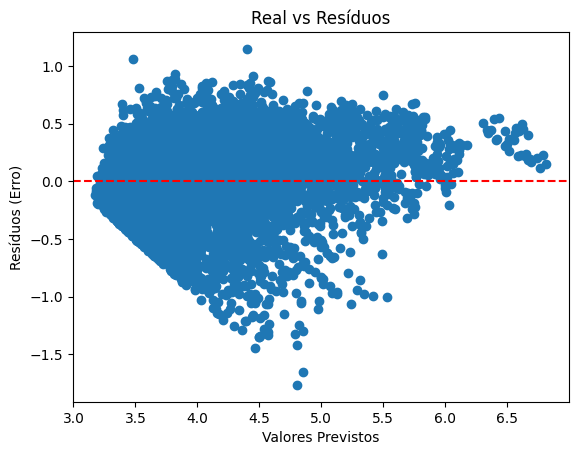

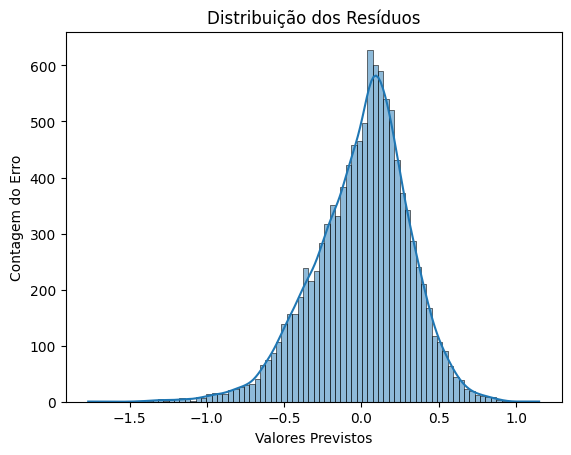

Ferrovia
8    0.40
1    0.29
9    0.29
2    0.25
7    0.25
12   0.24
4    0.24
10   0.23
11   0.23
3    0.21
Name: Erro, dtype: float64


In [75]:
############################################################################


# VALIDAÇÃO DO MODELO


############################################################################


# REPRODUTIBILIDADE
np.random.seed(2)


# GRAFICO DOS RESIDUOS + DISTRIBUIÇÃO DOS RESIDUOS + ANALISE DETALHADA DOS ERROS

residuos = y_test - y_pred

# Gráfico 1: resíduos vs valores previstos
plt.scatter(y_pred, residuos)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Valores Previstos')
plt.ylabel('Resíduos (Erro)')
plt.title('Real vs Resíduos')
plt.show()

# Gráfico 2: distribuição dos resíduos
sns.histplot(residuos, kde=True)
plt.xlabel('Valores Previstos')
plt.ylabel('Contagem do Erro')
plt.title('Distribuição dos Resíduos')
plt.show()

# Análise segmentada dos erros permite ver qual feature o modelo erra mais
valida_col_erros = pd.DataFrame({'Ferrovia': x_test['Codigo_Ferrovia'], 'Erro': abs(residuos)})
segmento = valida_col_erros.groupby('Ferrovia')['Erro'].mean().sort_values(ascending=False)

print(segmento.head(10))

In [79]:
###################################################################

# CRIANDO MODELO REFINADO COM OS ERROS

###################################################################


# DATAFRAME COM OS ERROS
resultados = x_test.copy()

# ADICIONANDO AS COLUNAS OBJETIVO
resultados['Valor LOG10'] = y_test
resultados['Valor Predito'] = y_pred
resultados['Residuo'] = y_test - y_pred
resultados['Erro Absoluto'] = abs(resultados['Residuo'])
resultados['Erro Percentual (%)'] = abs(resultados['Residuo'] / y_test) * 100


# FILTRANDO APENAS ERROS
erros_grandes = resultados[resultados['Residuo'] != 0]


# DEFININDO AS VARIAVEIS PARA O NOVO MODELO
x_refinado_erros = erros_grandes[x_train.columns]
y_refinado_erros = erros_grandes['Residuo']


# CRIANDO MODELO REFINADO
modelo_refinado_erros = RandomForestRegressor( n_estimators=300, 
                               max_depth=15, 
                               random_state=2, 
                               max_features='sqrt', 
                               min_samples_split=10, 
                               min_samples_leaf=5 )

# TREINANDO MODELO REFINADO
modelo_refinado_erros.fit(x_refinado_erros, y_refinado_erros)


# APLICANDO PREDIÇÃO
y_pred_refinado = modelo_refinado_erros.predict(x_test)


# PREDIÇÃO FINAL JUNTA OS RESULTADOS DO MODELO UM COM O MODELO REFINADO
y_pred_final = y_pred + y_pred_refinado
print('MODELO REFINADO TREINADO')
print('######################################\n')



# AVALIANDO MODELO REFINADO COM OS ERROS
###################################################################


MAE_FINAL  = mean_absolute_error(10 ** y_test, 10 ** y_pred_final)
RMSE_FINAL = np.sqrt(mean_squared_error(10 ** y_test, 10 ** y_pred_final))
MAPE_FINAL = mean_absolute_percentage_error(10 ** y_test, 10 ** y_pred_final)

print("MAE original:", MAE_REAL)
print("MAE refinado:", MAE_FINAL)
print("---------------------------")
print("RMSE original:", RMSE_REAL)
print("RMSE refinado:", RMSE_FINAL)
print("---------------------------")
print("MAPE original:", MAPE_REAL)
print("MAPE refinado:", MAPE_FINAL)


MODELO REFINADO TREINADO
######################################

MAE original: 38327.93362254919
MAE refinado: 30733.060322651494
---------------------------
RMSE original: 274067.86251617176
RMSE refinado: 221552.55162360633
---------------------------
MAPE original: 0.73332526725187
MAPE refinado: 0.5766628537420689


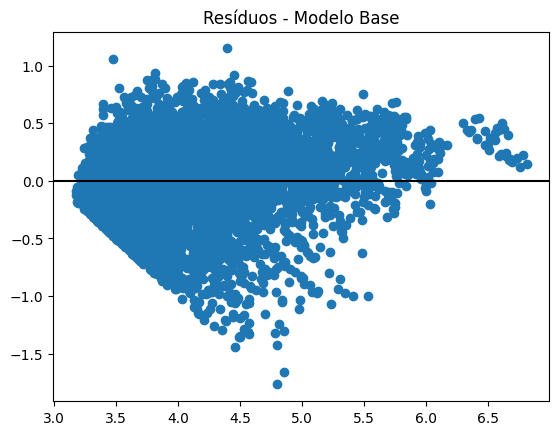

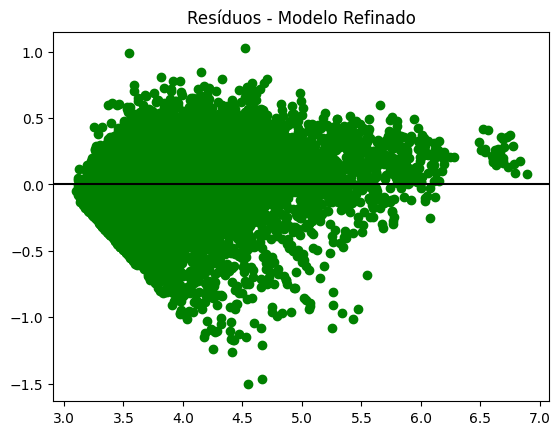

In [81]:
###################################################################

# AVALIANDO MODELO REFINADO COM OS ERROS

###################################################################

plt.scatter(y_pred, (y_test - y_pred))
plt.title("Resíduos - Modelo Base")
plt.axhline(0, color='black')
plt.show()

plt.scatter(y_pred_final, (y_test - y_pred_final), color='green')
plt.title("Resíduos - Modelo Refinado")
plt.axhline(0, color='black')
plt.show()

In [ ]:

'''
AQUI APLICAMOS O MODELO NO CENARIO FICTICIO PARA VER COMO ELE GENERALIZA COM OS DADOS EM UM CENÁRIO
DESCONHECIDO

'''


###################################################################

# APLICANDO MODELO NO CENARIO FICTÍCIO

###################################################################

# REPRODUTIBILIDADE
np.random.seed(2)

dataset_inicial = base_modelo_completa

# DUMMIES
#base_modelo = pd.get_dummies(base_original)

# TRANSFORMANDO COLUNAS
dataset_inicial['ANO'] = dataset_inicial['ANO'].astype(int)
dataset_inicial['MÊS'] = dataset_inicial['MÊS'].astype(int)
dataset_inicial['TU'] = dataset_inicial['TU'].astype(int)
dataset_inicial['TKU'] = dataset_inicial['TKU'].astype(int)


## BASE FINAL MODELO
base_cenario = dataset_inicial.select_dtypes(exclude=['object', 'category']).copy()

#DUPLICADOS
base_cenario = base_cenario.drop_duplicates()
base_cenario = base_cenario.fillna(0)

# LIMITANDO A BASE PARA 2023
base_cenario = base_cenario[base_cenario['ANO'] == 2023][list(base_cenario.columns)]

# OUTLIERS
q3 = base_cenario['TU'].quantile(0.75)
base_cenario = base_cenario[base_cenario['TU'] <= q3]

print(' O ano minimo é:', {base_cenario['ANO'].min()})
print('##################################################')
print(' Colunas da base final:\n', base_cenario.columns)
print('################### BASE CENARIO FICTICIO ###############################')
print(base_cenario.head(3))




 O ano minimo é: {2023}
##################################################
 Colunas da base final:
 Index(['TU', 'TKU', 'MÊS', 'ANO', 'FLAG_MEDIA_TU', 'FLAG_MEDIA_TKU',
       'Codigo_Ferrovia', 'Codigo_Mercadoria_ANTT', 'Codigo_Estacao_Origem',
       'Codigo_UF_Origem', 'Codigo_Estacao_Destino', 'Codigo_UF_Destino'],
      dtype='object')
################### BASE CENARIO FICTICIO ###############################
           TU      TKU  MÊS   ANO  FLAG_MEDIA_TU  FLAG_MEDIA_TKU  \
146130  11071  8310998    1  2023              0               0   
146131   7544  3945512    1  2023              0               0   
146132   9466  7080568    1  2023              0               0   

        Codigo_Ferrovia  Codigo_Mercadoria_ANTT  Codigo_Estacao_Origem  \
146130                0                      44                    252   
146131                0                      47                    216   
146132                0                      47                    216   

        Codig

In [ ]:

############################################################################

# APLICANDO MODELO


############################################################################

# REPRODUTIBILIDADE
pd.set_option('Float_format','{:.2f}'.format)

# CARREGANDO MODELO
modelo_cenario = load('ANTT_RANDOMFORESTREGRESSOR.joblib')

##CRIANDO A BASE DO ML UTILIZANDO O STATUS EM BINARIO
cenario_um_completo = base_cenario.drop(columns=['TU'])
cenario_um_target = base_cenario['TU'].values


# VALIDAÇÃO CRUZADA
kf_cenario = KFold(n_splits=5, shuffle= True, random_state=2)
cross_validation_cenario = cross_val_score(modelo_cenario, x, y, cv=kf, scoring='r2')


#FAZENDO AS PREVISOES NO CONJUNTO DE TESTE
pred_cenario_um = modelo_cenario.predict(cenario_um_completo)
acuracia_cenario = r2_score(cenario_um_target, pred_cenario_um)


#RESULTADOS 
print("----------------- ACURACIAS DO MODELO NO CENÁRIO -----------------------------------")
print(f"O tipo do modelo carregado é: {type(modelo)}")
print(f"acuracia para cada fold (cross-validation): {cross_validation_cenario}")
print(f"R2 média (cross-validation): {cross_validation_cenario.mean()*100}")
print(f"Desvio padrão (cross validation): {cross_validation_cenario.std()}")
print(f"acuracia final do modelo no cenario: {acuracia_cenario:.2f}")


'''
##########################################################

####  CENARIO COM MAX_DEPHT = 5

##########################################################

# ACURACIA 
consegue explicar cerca de 65% da variação da variável alvo (TU). Isso é melhor do que um chute aleatório, 
mas ainda distante de um bom ajuste (ideal: acima de 0,70 em muitos contextos). 
Pode indicar que variáveis importantes estão faltando ou que os dados têm muita variabilidade.


# DESVIO PADRÃO 
O valor estar zerado é incomum. Pode indicar que todas as folds usaram dados muito parecidos (baixa variabilidade) ou que algo 
está errado no particionamento.Sugere verificar se x e y foram bem embaralhados ou se há algum viés nos dados.


###########################################################################################

PARAMETROS

###########################################################################################


# MAX_DEPTH
Quando eu uso max_depth=5 o modelo cria arvores com maior profundidade, arvores profundas demais aprendem todos os detalhes (overfitting)
e arvores rasas demais max_depth=3 aprendem poucos detalhes (underfitting) ....esse ajuste na profundidade permite que as arvores aprendam melhor.

# SHUFFLE
Outro parametro importante no quesito governança e replicabilidade. SHUFFLE = TRUE na validação cruzada (definindo 
os KFOLDs) ela realiza uma reorganização/aleatoriedade nos dados e 
só depois eles são divididos nas amostras das arvores.
Traz a segurança de que seus dados estão aleatoriamente espalhados entres as amostras, sem viés.
Essa parte quebra a suposição do desvio padrão zero.


# VALIDAÇÃO CRUZADA
Tendo sido garantido o parametro de SHUFFLE = TRUE com a aleatoriedade e também devido aos resultados do 
modelo na base de treino terem o R2 para cada fold acima de 65: 
Acurácias para cada fold (cross-validation): [0.6893367  0.68714959 0.69417033 0.69013356 0.6925576]

Com isso podemos anular a hipotese de que há overffiting, que supomos ao ler o desvio padrão, pois os dados foram embaralhados no SHUFFLE = TRUE,
isso indica boa generalização.
'''



----------------- ACURACIAS DO MODELO NO CENÁRIO -----------------------------------
O tipo do modelo carregado é: <class 'sklearn.ensemble._forest.RandomForestRegressor'>
acuracia para cada fold (cross-validation): [0.6893367  0.68714959 0.69417033 0.69013356 0.6925576 ]
R2 média (cross-validation): 69.0669554276727
Desvio padrão (cross validation): 0.0024606536822105417
acuracia final do modelo no cenario: 0.65
MAE: 1931.7672736575075
RMSE: 3292.9858110767746
MAPE: 193.03%
MedAE: 993.75


'\n##########################################################\n\n####  CENARIO COM MAX_DEPHT = 5\n\n##########################################################\n\n# ACURACIA \nconsegue explicar cerca de 65% da variação da variável alvo (TU). Isso é melhor do que um chute aleatório, \nmas ainda distante de um bom ajuste (ideal: acima de 0,70 em muitos contextos). \nPode indicar que variáveis importantes estão faltando ou que os dados têm muita variabilidade.\n\n\n# ERRO ABSOLUTO MEDIO - (MAE mean absolute error)\nEm média, o modelo erra cerca de 1.931 unidades na previsão de TU. Esse valor deve ser \ninterpretado em relação à escala dos dados — se TU varia de 0 a milhões, \nesse erro pode ser tolerável; se não, pode ser alto.\n\n\n# RMSE - Raiz do erro quadratico médio - (Raise mean squared error)\nEsse erro penaliza mais fortemente grandes erros. Um RMSE muito maior que o MAE (como no nosso cenario 3.292) indica que \nhá outliers ou erros muito grandes em alguns casos que estão influenc

In [ ]:
'''

HIPÓTESE NULA:
    SERÁ QUE MEU MODELO CONSEGUE EXPLICAR AS TONELADAS TRANSPORTADAS
    APENAS COM AS DEMAIS COLUNAS DO NOSSO DATASET ?

REPSOSTA:
    A HIPÓTESE NULA FOI ACEITA, POIS O MODELO SÓ EXPLICA 65% DOS DADOS E APRESENTA HETEROCEDASTICIDADE,
    QUANTO MAIOR OS VALORES REAIS, MAIOR FOI O ERRO DO MEU MODELO.


'''